In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

In [15]:
train_path = "/kaggle/input/nlp-getting-started/train.csv"
test_path = "/kaggle/input/nlp-getting-started/test.csv"

train_data = pd.read_csv(train_path,index_col='id')
train_data

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [16]:
from sklearn.model_selection import train_test_split
X = train_data.drop('target',axis = 1)
Y = train_data['target']
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=.25)
train_x.shape, test_x.shape

((5709, 3), (1904, 3))

In [17]:
train_x.isna().mean()

keyword     0.008057
location    0.334559
text        0.000000
dtype: float64

In [20]:
from sklearn.base import BaseEstimator,TransformerMixin
import string
from nltk.corpus import stopwords
import regex as re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

class PreprocessText(BaseEstimator,TransformerMixin):
    def __init__(self,column):
        self.punc = string.punctuation
        self.column = column
        self.stop_words = stopwords.words('english')
        self.lemmatizer = WordNetLemmatizer()
        super().__init__()
    
    def fit(self,X,Y=None):
        return self
    
    def toLower(self,sent:str):
        if(type(sent) == str):
            return sent.lower()
        return sent
    
    def removePunc(self,sent:str):
        return sent.translate(str.maketrans("","",self.punc))
    
    def removeStopword(self,sent:str):
        words = word_tokenize(sent)
        return " ".join([w for w in words if w not in self.stop_words])
        
    def removeWhiteSpace(self,sent:str):
        return " ".join(sent.split())
        
    def removeDigits(self,sent):
        return " ".join(re.findall(r"\D+",sent))
    
    def removeMentions(self,text:str):
        # Remove Usernames and Mentions
        text = re.sub(r'@\w+', '', text)
        return text
    
    def removeLinks(self,text:str):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        return text
        
#     def lemmas(self,text):
#          # Lemmatization
#         words = word_tokenize(text)
#         tokens = [self.lemmatizer.lemmatize(word) for word in words]
#         return "".join(tokens)
    
    def transform(self,X,Y=None):
        X_transform = X.copy()
        X_transform[self.column] =  X[self.column].apply(self.removeMentions).apply(self.removeLinks).apply(self.toLower).apply(self.removePunc).apply(self.removeStopword).apply(self.removeDigits).apply(self.removeWhiteSpace)
        return X_transform[self.column]

In [21]:
PreprocessText('text').fit_transform(train_x)

id
4486     seriously look like get electrocuted blow dry ...
6601     brother dont want friendshipyou want add comme...
7254     physical sense helps preserve memories triple ...
120      truckcrash overturns fortworth interstate clic...
4702                    think every time go epicentre haha
                               ...                        
9102     whao pic yr old pkk suicide bomber detonated b...
2123     slightly diff catastrophe amp barry running so...
10550    nema ekiti distributed relief materials affect...
6635     megalpolis area petting party shiver fear inst...
10499                                          ember aware
Name: text, Length: 5709, dtype: object

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import  DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from time import time
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix,accuracy_score



preprocessor = ColumnTransformer(transformers=[("preprocess text",PreprocessText('text'),['text'])])
models = [("naive bayes",BernoulliNB()),
          ("random forest",RandomForestClassifier()),
          ("logistic regression",LogisticRegression()),
          ("support vector",SVC()),
          ("decision tree",DecisionTreeClassifier())]

scores = []
confussion_mat = []
times = []

for (name,model) in tqdm(models):
    t1 = time()
    print(f"processing model {name} ")
    pipe = Pipeline([('preprocess',PreprocessText('text')),
                     ("tfidf",TfidfVectorizer()),
                     ("classifier",model)
                    ])
    pipe.fit(train_x, train_y)
    y_pred = pipe.predict(test_x)
    score = accuracy_score(y_pred=y_pred,y_true=test_y)
    conf_mat = confusion_matrix(y_pred=y_pred,y_true=test_y)
    confussion_mat.append((name,conf_mat))
    scores.append((name,score))
    t2 = time()
    times.append((name,t2-t1))
    


  0%|          | 0/5 [00:00<?, ?it/s]

processing model naive bayes 
processing model random forest 
processing model logistic regression 
processing model support vector 
processing model decision tree 


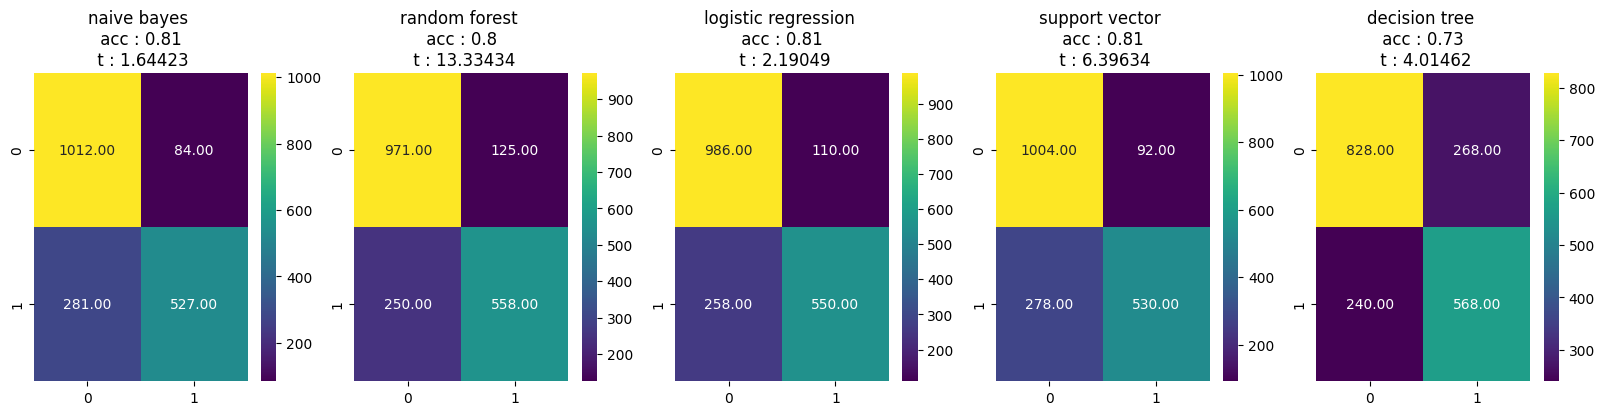

In [23]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
for i,(name,conf_mat) in enumerate(confussion_mat):
    sb.heatmap(conf_mat,ax=ax[i], cmap='viridis', annot=True, fmt=".2f")
    ax[i].set_title(f'{name} \n acc : {round(scores[i][1],2)} \n t : {round(times[i][1],5)}')
plt.show()

In [24]:
print(train_x.iloc[0]['text'])
print(PreprocessText('text').fit_transform(train_x).iloc[0])

seriously look like a get electrocuted after I blow dry my hair it's really attractive ??
seriously look like get electrocuted blow dry hair really attractive
